In [5]:
# 1. Built-in modules
import os
import sys

# 2. Third-party modules
import pandas as pd
from pprint import pprint
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import re

# 3. Custom modules

Classification avec Decision Tree et MLPClassifier

# Fonctions de base

In [ ]:
def get_unique_values_and_maxlength(dataset, column_name):
    """
    Compute unique values and maximum length for a given column of a dataset
    
    Args:
        dataset(dataset): A dataset with variables
        column_name(string): A column name
        
    Returns:
        A tuple containing a list of unique values for the given column
        and the maximum length of the values
    """
    unique_values = list(dataset[column_name].unique())
    max_length = max([len(str(value)) for value in unique_values])
    return  max_length, unique_values

In [108]:
def extract_columns(input_file, columns, chunk_size=10000):
    """
    Extrait les colonnes spécifiées du fichier CSV et les concatène dans un nouveau fichier CSV.
    
    Arguments :
    input_file : str - Chemin vers le fichier CSV d'entrée.
    columns : list - Liste des noms des colonnes à extraire.
    chunk_size : int - Taille des chunks à lire.
    """

    # Récupérer le nom de base du fichier CSV d'entrée
    base_filename = os.path.splitext(os.path.basename(input_file))[0]

    # Ouvrir le fichier CSV en utilisant pandas
    chunks = pd.read_csv(input_file, delimiter='\t', encoding="utf-8", chunksize=chunk_size, low_memory=False)

    # Nom du fichier CSV de sortie basé sur les colonnes sélectionnées
    output_file = f"{base_filename}.csv"

    # Itérer à travers les chunks et extraire les colonnes choisies
    with open(output_file, 'w', encoding="utf-8") as f_out:
        for i, chunk in enumerate(chunks):
            # Extraire les colonnes spécifiées
            extracted_columns = chunk[columns]
            # Écrire les données extraites dans le fichier de sortie
            extracted_columns.to_csv(f_out, index=False, header=(i == 0), encoding="utf-8")


# Vectorisation à partir du champ 'ingredients_text' directement
sans passer par l'étape 'création d'une colonne ingredients_tokens.

In [109]:
# On charge le fichier data_allergens_no_tags_gluten_presence.csv
data_allergens_no_tags_gluten_presence = pd.read_csv('data_allergens_no_tags_gluten_presence.csv')


/tmp/ipykernel_28838/4235003242.py:2: DtypeWarning: Columns (0,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_allergens_no_tags_gluten_presence = pd.read_csv('data_allergens_no_tags_gluten_presence.csv')


In [110]:
df = data_allergens_no_tags_gluten_presence

In [111]:
# nombre de lignes où la colonne 'gluten_presence' contient 1
print(f" Nombre de lignes contenant du gluten: {df['gluten_presence'].sum()}")
# nombre de lignes où la colonne 'gluten_presence' contient 0
print(f" Nombre de lignes ne contenant pas de gluten: {(df['gluten_presence'] == 0).sum()}")

 Nombre de lignes contenant du gluten: 108188
 Nombre de lignes ne contenant pas de gluten: 139292


In [112]:
# afficher la colonne 'ingredients_text'
df['ingredients_text']

0         eau graines de téguments de moutarde vinaigre ...
1         antioxydant : érythorbate de sodium, colorant ...
2         baguette Poite vin Pain baguette 50,6%: farine...
3         Paln suédois 42,6%: farine de BLÉ, eau, farine...
4         FROMAGE BLANC 7.896 MG 73,304, crème de marron...
                                ...                        
247475    FARINE DE BLÉ, carbonate de calcium, POUDRE DE...
247476    Viande de volaille 73 % ; peau de poulet 13 % ...
247477    ROASTED PEANUTS, SUGAR, LESS OF THAN 2% OF: MO...
247478    45 % massepain (44% amandes, sucre, sirop de g...
247479    farine de blé  eau porc 17 % chou barde de por...
Name: ingredients_text, Length: 247480, dtype: object

In [113]:
# nombre de ligne avec des valeurs manquantes dans la colonne 'ingredients_text'
print(f"Nombre de valeurs manquantes dans la colonne 'ingredients_text': {df['ingredients_text'].isna().sum()}")

Nombre de valeurs manquantes dans la colonne 'ingredients_text': 3452


In [114]:
# supprimer les lignes où la colonne 'ingredients_text' contient des valeurs manquantes
df = df.dropna(subset=['ingredients_text'])

In [115]:
# nombre de lignes où la colonne 'gluten_presence' contient 1
print(f"Nombre de lignes contenant du gluten: {df['gluten_presence'].sum()}")
# nombre de lignes où la colonne 'gluten_presence' contient 0
print(f"Nombre de lignes ne contenant pas de gluten: {(df['gluten_presence'] == 0).sum()}")
# nombre de ligne avec des valeurs manquantes dans la colonne 'ingredients_text'
print(f"Nombre de valeurs manquantes dans la colonne 'ingredients_text': {df['ingredients_text'].isna().sum()}")

Nombre de lignes contenant du gluten: 106752
Nombre de lignes ne contenant pas de gluten: 137276
Nombre de valeurs manquantes dans la colonne 'ingredients_text': 0


In [116]:
# rechercher la valeur "gluten" et la valeur "free" dans la colonne 'ingredients_text'

gluten_free = df['ingredients_text'].str.contains('gluten' and 'free', case=False, na=False).sum()

In [117]:
# afficher le dataframe qui contient la valeur "gluten" et la valeur "free" dans la colonne 'ingredients_text'
df[df['ingredients_text'].str.contains('gluten' and 'free', case=False, na=False)]
# affichier uniquement la colonne 'ingredients_text' du dataframe
df[df['ingredients_text'].str.contains('gluten' and 'free', case=False, na=False)]['ingredients_text']
# affichier le texte complet
print(df[df['ingredients_text'].str.contains('gluten' and 'free', case=False, na=False)]['ingredients_text'].values)

['Wheatflour contains Gluten (With Wheatflour, Calcium Carbonate, Iron, Niacin, Thiamin) • nu tt Salted Caramel (14%) (Sugar • Sweetened Condensed Milk (20%) (Whole Milk • Sugar) • Glucose Syrup • Palm Oil • Butter Oil (_Milk_) • Salt • Flavouring) • Belgian Milk Chocolate Chunks (13%) (Sugar • Dried Whole Milk • Cocoa Butter • Cocoa Mass • Emulsifier: Soya Lecithin • Vanilla Flavouring) • Sugar • Butter (_Milk_) • Palm Oil • Rapeseed Oil • Invert Sugar Syrup • Golden Syrup (Invert Sugar Syrup) • Fructose • Dried Skimmed Milk • Maltodextrin • Dried Free Range Egg • Molasses • Raising Agent: Sodium Bicarbonate, E450 • Flavouring • Salt.'
 'British Outdoor Bred Pork (90%) · Water · Gluten Free Crumb (Rice Flour, Chickpea Flour · Cornflour · Salt · Dextrose), Salt, Parsley · Lemon Zest · Dried Herbs (Thyme · Sage, Parsley, Oregano · Marjoram) · Ground Spices (Nutmeg, Mace · Coriander, Cayenne · Black Pepper) · Onions · Dextrose· Preservative: E223 (Sulphites) · Rapeseed Oil · Antioxidant:

=> Il faudra gérer ces cas où du gluten est prédit à cause de l'expression gluten free.

In [118]:
! pip install --upgrade pip
! pip install nltk

In [10]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation

In [120]:
# Télécharger les ressources nécessaires pour NLTK (exécuter une seule fois)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/matthieu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matthieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/matthieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [122]:
# Nous allons créer la liste des stopwords en dehors de la fonction tokenize, pour éviter de la recalculer à chaque appel de la fonction.

# Liste des langues pour lesquelles nous voulons des stopwords
langues = ['english', 'french', 'german']
# Concaténer toutes les listes de stopwords pour les différentes langues
stopwords_all = []
for langue in langues:
    stopwords_all.extend(stopwords.words(langue))


In [7]:
# Ecrivons la fonction de tokenisation, nous voulons qu'elle supprime également les valeurs numériques

def tokenize(texte):

    # Tokenisation du texte
    tokens = word_tokenize(texte)

    # Suppression de la ponctuation, des valeurs numériques et des mots vides (stop words)
    tokens_cleaned = [mot.replace('_', '').replace('-', '').lower() for mot in tokens if mot not in punctuation 
                      and mot.lower() not in stopwords_all 
                      and not bool(re.match(r'\d', mot))
                      and len(mot) > 2]
                    

    return tokens_cleaned


In [124]:
texte = df['ingredients_text'].iloc[2]
tokenize(texte)


['baguette',
 'poite',
 'vin',
 'pain',
 'baguette',
 'farine',
 'blé',
 'eau',
 'sel',
 'levure',
 'gluten',
 'farine',
 'ble',
 'maité',
 'levure',
 'désactivée',
 'acide',
 'ascorbique',
 'garniture',
 'fromage',
 'michèvre',
 'lait',
 'pasteurisé',
 'lait',
 'vache',
 'lait',
 'chèvre',
 'sel',
 'ferments',
 'lactiques',
 'daffinage',
 'coagulant',
 'tomate',
 'saladg',
 'huile',
 "d'olive",
 'basilic']

In [125]:
texte = df['additives_en'].iloc[1]
print(texte)

E150 - Caramel,E160a - Carotene,E202 - Potassium sorbate,E316 - Sodium erythorbate,E466 - Sodium carboxy methyl cellulose


In [126]:
tokenize(texte)

['e150',
 'caramel',
 'e160a',
 'carotene',
 'e202',
 'potassium',
 'sorbate',
 'e316',
 'sodium',
 'erythorbate',
 'e466',
 'sodium',
 'carboxy',
 'methyl',
 'cellulose']

In [127]:
# ajout de la colonne 'ingredients_tokens' au dataframe
df['ingredients_tokens'] = df['ingredients_text'].apply(tokenize)

/tmp/ipykernel_28838/2528447956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients_tokens'] = df['ingredients_text'].apply(tokenize)


In [128]:
df.head().T

,0,1,2,3,4
code,100,1199,2264,3827,4794
creator,del51,kiliweb,kiliweb,kiliweb,kiliweb
created_datetime,2015-10-11T14:09:21Z,2018-02-05T12:26:34Z,2018-02-12T12:52:40Z,2018-02-15T10:44:33Z,2018-02-19T10:55:56Z
product_name,moutarde au moût de raisin,Solène céréales poulet,Baguette Poitevin,Suedois saumon,Fromage blanc à la creme de marron
generic_name,NaN,NaN,NaN,NaN,NaN
categories,"Condiments, Sauces, Moutardes, groceries",NaN,NaN,NaN,NaN
categories_tags,"condiments,sauces,mustards,groceries",NaN,NaN,NaN,NaN
categories_en,"Condiments,Sauces,Mustards,Groceries",NaN,NaN,NaN,NaN
ingredients_text,eau graines de téguments de moutarde vinaigre ...,"antioxydant : érythorbate de sodium, colorant ...","baguette Poite vin Pain baguette 50,6%: farine...","Paln suédois 42,6%: farine de BLÉ, eau, farine...","FROMAGE BLANC 7.896 MG 73,304, crème de marron..."
ingredients_tags,eau-graines-de-teguments-de-moutarde-vinaigre-...,"antioxidant,colour,tomato,vegetable,fruit-vege...","baguette-poite-vin-pain-baguette,water,salt,ye...","paln-suedois,water,rye-flour,flour,cereal-flou...","fromage-blanc-7-896-mg-73-304,creme-de-marron-..."


In [129]:
df['ingredients_text']

0         eau graines de téguments de moutarde vinaigre ...
1         antioxydant : érythorbate de sodium, colorant ...
2         baguette Poite vin Pain baguette 50,6%: farine...
3         Paln suédois 42,6%: farine de BLÉ, eau, farine...
4         FROMAGE BLANC 7.896 MG 73,304, crème de marron...
                                ...                        
247475    FARINE DE BLÉ, carbonate de calcium, POUDRE DE...
247476    Viande de volaille 73 % ; peau de poulet 13 % ...
247477    ROASTED PEANUTS, SUGAR, LESS OF THAN 2% OF: MO...
247478    45 % massepain (44% amandes, sucre, sirop de g...
247479    farine de blé  eau porc 17 % chou barde de por...
Name: ingredients_text, Length: 244028, dtype: object

In [130]:
df['ingredients_tokens'][1]

['antioxydant',
 'érythorbate',
 'sodium',
 'colorant',
 'caramel',
 'origine',
 'tomate',
 'mayonnaise',
 'huile',
 'colza',
 'eau',
 'jaunes',
 "d'oeuf",
 'vinaigre',
 'moutarde',
 'eau',
 'graines',
 'moutarde',
 'sel',
 'vinaigre',
 'curcuma',
 'sel',
 'dextrose',
 'stabilisateur',
 'gomme',
 'cellulose',
 'conservateur',
 'sorbate',
 'potassium',
 'colorant',
 'carotène',
 'arôme']

In [131]:
df['ingredients_tokens']

0         [eau, graines, téguments, moutarde, vinaigre, ...
1         [antioxydant, érythorbate, sodium, colorant, c...
2         [baguette, poite, vin, pain, baguette, farine,...
3         [paln, suédois, farine, blé, eau, farine, seig...
4         [fromage, blanc, crème, marron, vanillée, sucr...
                                ...                        
247475    [farine, blé, carbonate, calcium, poudre, lait...
247476    [viande, volaille, peau, poulet, eau, conserva...
247477    [roasted, peanuts, sugar, less, molasses, full...
247478    [massepain, amandes, sucre, sirop, glucose, fr...
247479    [farine, blé, eau, porc, chou, barde, porc, sa...
Name: ingredients_tokens, Length: 244028, dtype: object

In [132]:
# Exporter le df en csv
df.to_csv('data_allergens_ingredients_tokenized.csv', index=False)

# Quel type de modèle choisir ?

In [133]:
# Importer le df
df = pd.read_csv('data_allergens_ingredients_tokenized.csv')

/tmp/ipykernel_28838/1782296754.py:2: DtypeWarning: Columns (0,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_allergens_ingredients_tokenized.csv')


In [134]:
# nombre d'échantillons dans le dataframe
print(f"Nombre d'échantillons dans le dataframe: {df.shape[0]}")

Nombre d'échantillons dans le dataframe: 244028


In [135]:
# nombre moyen de mots par échantillon
moyenne_mots = df['ingredients_tokens'].apply(len).mean()
print(f"Nombre moyen de mots par échantillon: {moyenne_mots:.2f}")

Nombre moyen de mots par échantillon: 410.67


In [136]:
# Rapport rapport du nombre d’échantillons au nombre de mots par échantillon
rapport = df.shape[0] / moyenne_mots
print(f"Rapport du nombre d’échantillons au nombre de mots par échantillon: {rapport:.2f}")

Rapport du nombre d’échantillons au nombre de mots par échantillon: 594.22


D'après cette source je devrais me tourner vers : https://medium.com/big-apps-tech/nlp-natural-language-processing-text-classification-workflow-take-n-grams-as-input-e549037b658d

"Lorsque la valeur de ce rapport est petite (<1500), les modèles qui prennent les n-grammes en entrée fonctionnent mieux que les modèles de séquence. Lorsque la valeur de ce rapport est grande (> = 1500), les modèles de séquence qui fonctionnent le mieux."

Mais je ne m'intéresse pas aux séquences puisque j'ai des listes d'ingrédients. je suis donc une approche 'sac de mots'. 
MAIS: je ne dois  oublier que les ingrédients peuvent être classés par ordre de quantité présente dans le produit(l'ordre des mots contient bien de l'info)

In [137]:
# Verification
# nombre de NaN dans la colonne 'ingredients_tokens'
print(f"Nombre de NaN dans la colonne 'ingredients_tokens': {df['ingredients_tokens'].isna().sum()}")
# Nombre de Nan dans la colonne 'gluten_presence'
print(f"Nombre de NaN dans la colonne 'gluten_presence': {df['gluten_presence'].isna().sum()}")

Nombre de NaN dans la colonne 'ingredients_tokens': 0
Nombre de NaN dans la colonne 'gluten_presence': 0


# Vectorisation One-hot encoding

In [138]:
# charger data_allergens_ingredients_tokenized.csv
df = pd.read_csv('data_allergens_ingredients_tokenized.csv')

/tmp/ipykernel_28838/2077198670.py:2: DtypeWarning: Columns (0,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_allergens_ingredients_tokenized.csv')


In [139]:
df['ingredients_tokens']

0         ['eau', 'graines', 'téguments', 'moutarde', 'v...
1         ['antioxydant', 'érythorbate', 'sodium', 'colo...
2         ['baguette', 'poite', 'vin', 'pain', 'baguette...
3         ['paln', 'suédois', 'farine', 'blé', 'eau', 'f...
4         ['fromage', 'blanc', 'crème', 'marron', 'vanil...
                                ...                        
244023    ['farine', 'blé', 'carbonate', 'calcium', 'pou...
244024    ['viande', 'volaille', 'peau', 'poulet', 'eau'...
244025    ['roasted', 'peanuts', 'sugar', 'less', 'molas...
244026    ['massepain', 'amandes', 'sucre', 'sirop', 'gl...
244027    ['farine', 'blé', 'eau', 'porc', 'chou', 'bard...
Name: ingredients_tokens, Length: 244028, dtype: object

In [140]:
# afficher la dernière ligne du df
df.tail()

,code,creator,created_datetime,product_name,generic_name,categories,categories_tags,categories_en,ingredients_text,ingredients_tags,...,additives_en,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,main_category,main_category_en,gluten_presence,ingredients_tokens
244023,990530101021839124,kiliweb,2020-10-22T12:25:54Z,Cookie triple chocolat x4,NaN,"Snacks, Snacks sucrés, Biscuits et gâteaux, Bi...","snacks,sweet-snacks,biscuits-and-cakes,biscuit...","Snacks,Sweet snacks,Biscuits and cakes,Biscuit...","FARINE DE BLÉ, carbonate de calcium, POUDRE DE...","wheat-flour,cereal,flour,wheat,cereal-flour,e1...",...,"E322 - Lecithins,E322i - Lecithin,E500 - Sodiu...",Sugary snacks,Biscuits and cakes,biscuits-and-cakes,"sugary-snacks,biscuits-and-cakes","Sugary snacks,Biscuits and cakes",cookies-with-milk-chocolate,Cookies with milk chocolate,1,"['farine', 'blé', 'carbonate', 'calcium', 'pou..."
244024,990530101110772053,kiliweb,2023-09-29T06:53:50Z,Saucisses de volaille,NaN,"Viandes et dérivés, Charcuteries, Saucisses, S...","meats-and-their-products,prepared-meats,sausag...","Meats and their products,Prepared meats,Sausag...",Viande de volaille 73 % ; peau de poulet 13 % ...,"poultry-meat,poultry,chicken-skin,poultry-skin...",...,"E262 - Sodium acetates,E326 - Potassium lactate",Fish Meat Eggs,Processed meat,processed-meat,"fish-meat-eggs,processed-meat","Fish‚ Meat‚ Eggs,Processed meat",poultry-sausages,Poultry sausages,1,"['viande', 'volaille', 'peau', 'poulet', 'eau'..."
244025,99227777,product-scan-com,2022-09-18T00:42:46Z,Creamy Peanut Butter,NaN,"Plant-based foods and beverages,Plant-based fo...","plant-based-foods-and-beverages,plant-based-fo...","Plant-based foods and beverages,Plant-based fo...","ROASTED PEANUTS, SUGAR, LESS OF THAN 2% OF: MO...","roasted-peanuts,nut,peanut,sugar,added-sugar,d...",...,E471 - Mono- and diglycerides of fatty acids,Cereals and potatoes,Legumes,legumes,"cereals-and-potatoes,legumes","Cereals and potatoes,Legumes",peanut-butters,Peanut butters,0,"['roasted', 'peanuts', 'sugar', 'less', 'molas..."
244026,99515874,kiliweb,2017-12-17T13:58:05Z,Mini stollen,NaN,stollen,"snacks,sweet-snacks,festive-foods,biscuits-and...","Snacks,Sweet snacks,Festive foods,Biscuits and...","45 % massepain (44% amandes, sucre, sirop de g...","marzipan,wheat-flour,cereal,flour,wheat,cereal...",...,NaN,Sugary snacks,Biscuits and cakes,biscuits-and-cakes,"sugary-snacks,biscuits-and-cakes","Sugary snacks,Biscuits and cakes",stollen,Stollen,1,"['massepain', 'amandes', 'sucre', 'sirop', 'gl..."
244027,99885434,openfoodfacts-contributors,2019-07-08T10:52:02Z,raviolis pékinois surgelés,NaN,"Surgelés, Plats préparés, Plats à base de pâte...","frozen-foods,meals,pasta-dishes,stuffed-pastas...","Frozen foods,Meals,Pasta dishes,Stuffed pastas...",farine de blé eau porc 17 % chou barde de por...,farine-de-ble-eau-porc-17-chou-barde-de-porc-s...,...,"E150a - Plain caramel,E621 - Monosodium glutam...",Composite foods,One-dish meals,one-dish-meals,"composite-foods,one-dish-meals","Composite foods,One-dish meals",frozen-ravioli,Frozen ravioli,1,"['farine', 'blé', 'eau', 'porc', 'chou', 'bard..."


In [141]:
texte = df['ingredients_tokens'][0]
print(texte)
print(type(texte))


['eau', 'graines', 'téguments', 'moutarde', 'vinaigre', 'vin', 'rouge', 'sel', 'vin', 'rouge', 'sucre', 'moût', 'raisin', 'oignons', 'colorants', 'extraits', 'carotte', 'extrait', 'paprika', 'huile', 'tournesol', 'moutarde', 'sel', 'cette', 'moutarde', 'uniquement', 'disponible', 'chez', 'courte', 'paille']
<class 'str'>


In [142]:
# df['ingredients_tokens'][0] est considéré comme du texte (str)
# il faut le transformer en liste

texte = eval(texte)
print(texte)
for mot in texte:
    print(mot)

['eau', 'graines', 'téguments', 'moutarde', 'vinaigre', 'vin', 'rouge', 'sel', 'vin', 'rouge', 'sucre', 'moût', 'raisin', 'oignons', 'colorants', 'extraits', 'carotte', 'extrait', 'paprika', 'huile', 'tournesol', 'moutarde', 'sel', 'cette', 'moutarde', 'uniquement', 'disponible', 'chez', 'courte', 'paille']
eau
graines
téguments
moutarde
vinaigre
vin
rouge
sel
vin
rouge
sucre
moût
raisin
oignons
colorants
extraits
carotte
extrait
paprika
huile
tournesol
moutarde
sel
cette
moutarde
uniquement
disponible
chez
courte
paille


In [5]:
# vectorisation des tokens
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser le vectoriseur
vectorizer = CountVectorizer()

# joindre les tokens afin de pouvoir les traiter
# texte = df['ingredients_tokens'].apply(lambda x: ' '.join(x))

# Appliquer le vectoriseur sur les tokens
X = vectorizer.fit_transform(texte)

NameError: name 'texte' is not defined

In [144]:
print(X.toarray())
# toarray() permet de visualiser la matrice creuse sous forme de tableau

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

le vectorizer fonctionne !

In [145]:
# Vectorisons les tokens de la colonne 'ingredients_tokens' du dataframe df.

data = df['ingredients_tokens']

# creating the feature matrix 
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=500)
X = matrix.fit_transform(data).toarray()

print(X)







[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [146]:
X.shape

(244028, 500)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 


In [148]:
# Diviser les données en features (X) et target (y)
X
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle d'arbre de décision
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8807728557964185


In [149]:
# On a amélioré l'accuracy de 0.01, grâce au meilleur nettoyage (_ et - supprimés)

In [150]:
# tester le modèle avec un nouvel échantillon
nouvel_échantillon = ['lait, sucre, oeufs, sel, glutenfree']
nouvel_échantillon_vectorisé = matrix.transform(nouvel_échantillon).toarray()
prediction = clf.predict(nouvel_échantillon_vectorisé)

if prediction[0] == 1:
    print("Attention: Présence de gluten")
else :
    print("Pas de gluten, faites vous plaisir")


Pas de gluten, faites vous plaisir


glutenfree est detecté comme sans gluten, mais pas 'gluten free'

Evaluation

In [8]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score, precision_score
# classification report est un super outil de rapport.
from sklearn.model_selection import learning_curve # pour comprendre si le modèle est en underfitting ou overfitting.
# Pour ensuite évaluer s'il faut créer des polynômes ou faire de la sélection de features.
import numpy as np

In [152]:
model = DecisionTreeClassifier()

In [2]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score, precision_score
# classification report est un super outil de rapport.
from sklearn.model_selection import learning_curve # pour comprendre si le modèle est en underfitting ou overfitting.
# Pour ensuite évaluer s'il faut créer des polynômes ou faire de la sélection de features.
import numpy as np

def evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Lines in ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"f1_score: {round(f1_score(y_test, y_pred), 2)}")
    print(f"recall_score: {round(recall_score(y_test, y_pred), 2)}")
    print(f"precision_score: {round(precision_score(y_test, y_pred), 2)}")
    

    if display_learning_curve == True:
        # learning curve pour comprendre si le modèle est en underfitting ou overfitting.
        N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1' , train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(12,8))
        plt.plot(N, train_score.mean(axis=1), label='train score') # cf vidéo 21.30
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.xlabel('Training Examples')
        plt.ylabel('F1 Score')
        plt.legend()

In [154]:
# evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=True)

# Bi-grammes
L'idée est de vectoriser des bigrammes
- évaluer si cela améliore les scores
- évaluer si cela permet de remédier au fait que l'expression 'gluten-free' est détectée comme contenant du gluten.

In [155]:
# Vectorisons les tokens de la colonne 'ingredients_tokens' du dataframe df.
# traitons les 1-grammes et les 2-grammes

data = df['ingredients_tokens']

# creating the feature matrix 
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=500, ngram_range=(1, 2)) # 1 et 2 grammes
X = matrix.fit_transform(data).toarray()

print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [156]:
# Diviser les données en features (X) et target (y)
X
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle d'arbre de décision
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8745441134286768


Le score semble légèrement moins bon. (0.875 contre 0.880 avec des monogrammes)
Il faut toutefois comparer les recall scores, et les prédictions de l'expression 'gluten  free'

In [157]:
model = DecisionTreeClassifier()
evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=True)

Lines in 
[[25216  2375]
 [ 3700 17515]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     27591
           1       0.88      0.83      0.85     21215

    accuracy                           0.88     48806
   macro avg       0.88      0.87      0.87     48806
weighted avg       0.88      0.88      0.87     48806

f1_score: 0.85
recall_score: 0.83
precision_score: 0.88


KeyboardInterrupt: 

In [ ]:
# tester le modèle avec un nouvel échantillon
nouvel_échantillon = ['oeuf, farine, sucre, sel']
nouvel_échantillon_vectorisé = matrix.transform(nouvel_échantillon).toarray()
prediction = clf.predict(nouvel_échantillon_vectorisé)

if prediction[0] == 1:
    print("Attention: Présence de gluten")
else :
    print("Pas de gluten, faites vous plaisir")

Attention: Présence de gluten


2-grammes uniquement (ngram_range=(2, 2))

In [ ]:
# Vectorisons les tokens de la colonne 'ingredients_tokens' du dataframe df.
# traitons uniquement les 2-grammes (ngram_range=(2, 2))

data = df['ingredients_tokens']

# creating the feature matrix 
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=500, ngram_range=(2, 2))
X = matrix.fit_transform(data).toarray()

print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Diviser les données en features (X) et target (y)
X
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle d'arbre de décision
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8322542310371676


On est moins bons !

In [ ]:
# tester le modèle avec un nouvel échantillon
nouvel_échantillon = ['blé']
nouvel_échantillon_vectorisé = matrix.transform(nouvel_échantillon).toarray()
prediction = clf.predict(nouvel_échantillon_vectorisé)

if prediction[0] == 1:
    print("Attention: Présence de gluten")
else :
    print("Pas de gluten, faites vous plaisir")

Pas de gluten, faites vous plaisir


Le modèle ne détecte plus le gluten !

# Tweaking du decision tree à 1-gram
essayons de forcer la création de token 'glutenfree', 'sansgluten', 'ohnegluten' à la place de 'gluten free', 'sans gluten', 'ohne gluten'.

In [29]:
# charger data_allergens_ingredients_tokenized.csv
df = pd.read_csv('data_allergens_ingredients_tokenized.csv')

/tmp/ipykernel_48606/2077198670.py:2: DtypeWarning: Columns (0,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_allergens_ingredients_tokenized.csv')


In [30]:
# Nous allons créer la liste des stopwords en dehors de la fonction tokenize, pour éviter de la recalculer à chaque appel de la fonction.

# Liste des langues pour lesquelles nous voulons des stopwords
langues = ['english', 'french', 'german']
# Concaténer toutes les listes de stopwords pour les différentes langues
stopwords_all = []
for langue in langues:
    stopwords_all.extend(stopwords.words(langue))

In [31]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

def tokenize(texte):
    # Tokenisation du texte
    tokens = word_tokenize(texte)

    # Suppression de la ponctuation, des valeurs numériques et des mots vides (stop words)
    tokens_cleaned = []
    i = 0
    while i < len(tokens):
        if (tokens[i].lower() == 'gluten' and i < len(tokens) - 1 and tokens[i+1].lower() == 'free') or \
        (tokens[i].lower() == 'ohne' and i < len(tokens) - 1 and tokens[i+1].lower() == 'gluten') or \
           (tokens[i].lower() == 'sans' and i < len(tokens) - 1 and tokens[i+1].lower() == 'gluten'):
            tokens_cleaned.append(tokens[i].lower() + tokens[i+1].lower())
            i += 2
        else:
            token = tokens[i].replace('_', '').replace('-', '').lower()
            if token not in punctuation and token.lower() not in stopwords.words('english') and not bool(re.match(r'\d', token)) and len(token) > 2:
                tokens_cleaned.append(token)
            i += 1

    return tokens_cleaned


In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

# Nous allons créer la liste des stopwords en dehors de la fonction tokenize, pour éviter de la recalculer à chaque appel de la fonction.

# Liste des langues pour lesquelles nous voulons des stopwords
langues = ['english', 'french', 'german']
# Concaténer toutes les listes de stopwords pour les différentes langues
stopwords_all = []
for langue in langues:
    stopwords_all.extend(stopwords.words(langue))


def tokenize(texte):
    # Tokenisation du texte
    tokens = word_tokenize(texte)

    # Suppression de la ponctuation, des valeurs numériques et des mots vides (stop words)
    tokens_cleaned = []
    i = 0
    while i < len(tokens):
        if (tokens[i].lower() == 'gluten' and i < len(tokens) - 1 and tokens[i+1].lower() == 'free') or \
        (tokens[i].lower() == 'ohne' and i < len(tokens) - 1 and tokens[i+1].lower() == 'gluten') or \
           (tokens[i].lower() == 'sans' and i < len(tokens) - 1 and tokens[i+1].lower() == 'gluten'):
            tokens_cleaned.append(tokens[i].lower() + tokens[i+1].lower())
            i += 2
        else:
            token = tokens[i].replace('_', '').replace('-', '').lower()
            if token not in punctuation and token.lower() not in stopwords_all and not bool(re.match(r'\d', token)) and len(token) > 2:
                tokens_cleaned.append(token)
            i += 1

    return tokens_cleaned

In [8]:
print(stopwords_all)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
texte = 'ohne gluten sans gluten gluten free sugar, salt, eggs, milk, 2ml de beurre'
tokenize(texte)


['ohnegluten',
 'sansgluten',
 'glutenfree',
 'sugar',
 'salt',
 'eggs',
 'milk',
 'beurre']

In [4]:
# charger data_allergens_ingredients_tokenized.csv
df = pd.read_csv('data_allergens_ingredients_tokenized.csv')

/tmp/ipykernel_14199/2077198670.py:2: DtypeWarning: Columns (0,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_allergens_ingredients_tokenized.csv')


In [6]:
# Appliquer la fonction tokenize sur la colonne 'ingredients_text' du dataframe et ajouter le résultat dans une nouvelle colonne 'ingredients_tokens'
df['ingredients_tokens'] = df['ingredients_text'].apply(tokenize)

Essayons le classifier sur notre nouveau df.

In [7]:
# Tests: cherche le mot 'sansgluten' dans la colonne 'ingredients_tokens', et affiche le contenu de la colonne 'ingredients_text' pour les lignes où le mot est trouvé
df[df['ingredients_tokens'].apply(lambda x: 'sansgluten' in x)]['ingredients_tokens']
# affiche le texte complet
print(df[df['ingredients_tokens'].apply(lambda x: 'sansgluten' in x)]['ingredients_tokens'].values)


[list(['isolat', 'protéines', 'soja', 'fructose', 'inuline', 'fibres', "d'avoine", 'sansgluten', 'huile', 'soja', 'mélange', 'minéraux', 'citrate', 'calcium', 'oxyde', 'magnésium', 'fumarate', 'ferreux', 'sélénite', 'sodium', 'oxyde', 'zinc', 'carbonate', 'manganèse', 'chlorure', 'chrome', 'iii', 'iodure', 'potassium', 'citrate', 'cuivre', 'poudre', 'café', 'décaféiné', 'phosphate', 'potassium', 'émulsifiant', 'lécithine', 'soja', 'arôme', 'naturel', 'poudre', 'lin', 'biologique1', 'épaississants', 'gomme', 'xanthane', 'gomme', 'guar', 'colorant', 'caramel', 'mélange', 'vitamines', 'acide', 'lascorbique', 'vit', 'acétate', 'dlalphatocophéryle', 'vit', 'nicotinamide', 'niacine', 'acétate', 'rétinyle', 'vit', 'dpantothénate', 'calcium', 'acide', 'pantothénique', 'dbiotine', 'biotine', 'cholécalciférol', 'vit', 'phylloquinone', 'vit', 'chlorhydrate', 'pyridoxine', 'vit', 'chlorhydrate', 'thiamine', 'vit', 'cyanocobalamine', 'vit', 'b12', 'riboflavine', 'vit', 'acide', 'ptéroylmonoglutamiq

la fonction de tokenisation a bien fonctionné. Exportons ce df.

In [9]:
# Exporter le df en csv
df.shape
df.to_csv('data_allergens_ingredients_tokenized_glutenfree.csv', index=False)


Essayons sur notre classifieur

In [6]:
df = pd.read_csv('data_allergens_ingredients_tokenized_glutenfree.csv')

/tmp/ipykernel_29241/2899512039.py:1: DtypeWarning: Columns (0,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_allergens_ingredients_tokenized_glutenfree.csv')


In [11]:
# Vectorisons les tokens de la colonne 'ingredients_tokens' du dataframe df.
# Cette colonne a déjà été tokénisée pour accélerer les calculs

data = df['ingredients_tokens']

# creating the feature matrix (vectorisation)
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=500)
X = matrix.fit_transform(data).toarray()
print(f"Shape of X: {X.shape}")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 

# Diviser les données en features (X) et target (y)
X
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle d'arbre de décision
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Shape of X: (244028, 500)
Accuracy: 0.8822275949678319


In [18]:
# tester le modèle avec un nouvel échantillon
nouvel_échantillon = 'sucre, sel'
nouvel_échantillon_tokénisé = tokenize(nouvel_échantillon)
print(f"échantillon tokénisé: {nouvel_échantillon_tokénisé}")

nouvel_échantillon_vectorisé = matrix.transform(nouvel_échantillon_tokénisé).toarray()
prediction = clf.predict(nouvel_échantillon_vectorisé)

if prediction[0] == 1:
    print("Attention: Présence de gluten")
else :
    print("Pas de gluten, faites vous plaisir")

échantillon tokénisé: ['sucre', 'sel']
Pas de gluten, faites vous plaisir


In [11]:
# A présent je voudrais faire une un grid search pour trouver les meilleurs hyperparamètres pour le modèle d'arbre de décision
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Définir les distributions des hyperparamètres à rechercher
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, randint(1, 100)],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialiser le modèle d'arbre de décision
clf = DecisionTreeClassifier()

# Créer l'objet RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Exécuter la recherche aléatoire sur les données d'entraînement
random_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Best parameters found:")
print(random_search.best_params_)

# Afficher la meilleure précision
print("Best accuracy found:", random_search.best_score_)

# Utiliser le meilleur modèle pour faire des prédictions sur l'ensemble de test
best_clf = random_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calculer l'exactitude du meilleur modèle sur l'ensemble de test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model:", accuracy)


/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3.

Best parameters found:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13}
Best accuracy found: 0.867151218777259
Accuracy of the best model: 0.8566159898373151


In [12]:
# Vectoriser les tokens de la colonne 'ingredients_tokens' du dataframe df.
data = df['ingredients_tokens']

# Créer la matrice des caractéristiques (vectorisation)
matrix = CountVectorizer(max_features=500)
X = matrix.fit_transform(data).toarray()
print(f"Shape of X: {X.shape}")

# Diviser les données en features (X) et target (y)
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir les meilleurs paramètres trouvés par RandomizedSearchCV
best_params = {
    'criterion': random_search.best_params_['criterion'],
    'max_depth': random_search.best_params_['max_depth'],
    'min_samples_split': random_search.best_params_['min_samples_split'],
    'min_samples_leaf': random_search.best_params_['min_samples_leaf'],
    'max_features': random_search.best_params_['max_features']
}

# Initialiser et entraîner le modèle d'arbre de décision avec les meilleurs paramètres
best_clf = DecisionTreeClassifier(**best_params)
best_clf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = best_clf.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model:", accuracy)


Shape of X: (244028, 500)
Accuracy of the best model: 0.8615948858746876


Lines in 
[[24808  2783]
 [ 3942 17273]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     27591
           1       0.86      0.81      0.84     21215

    accuracy                           0.86     48806
   macro avg       0.86      0.86      0.86     48806
weighted avg       0.86      0.86      0.86     48806

f1_score: 0.84
recall_score: 0.81
precision_score: 0.86


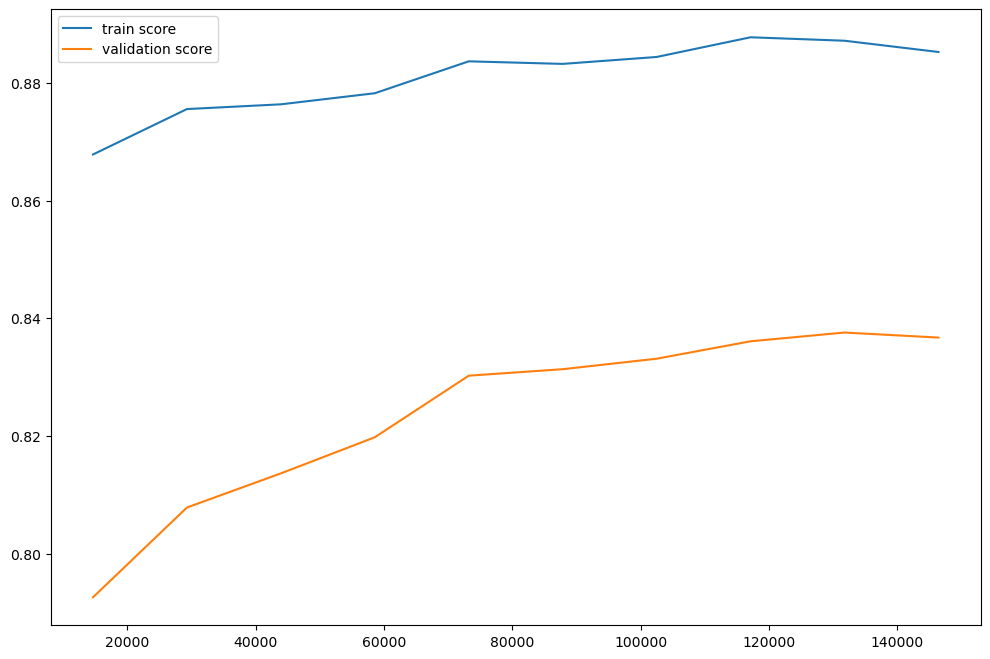

In [15]:
model = best_clf
evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=True)

Utilisons ces best parameters dans le modèle:

C'est moins bien que le classifier de base. Essayons un grid search pour trouver les meilleurs hyperparamètres, plutôt qu'un randomized search.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Vectoriser les tokens de la colonne 'ingredients_tokens' du dataframe df.
data = df['ingredients_tokens']

# Créer la matrice des caractéristiques (vectorisation)
matrix = CountVectorizer(max_features=500)
X = matrix.fit_transform(data).toarray()
print(f"Shape of X: {X.shape}")

# Diviser les données en features (X) et target (y)
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialiser le modèle d'arbre de décision
clf = DecisionTreeClassifier()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Exécuter la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Best parameters found:")
print(grid_search.best_params_)

# Afficher la meilleure précision
print("Best accuracy found:", grid_search.best_score_)

# Utiliser le meilleur modèle pour faire des prédictions sur l'ensemble de test
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calculer l'exactitude du meilleur modèle sur l'ensemble de test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model:", accuracy)


Shape of X: (244028, 500)


/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/matthieu/anaconda3/envs/dsproj/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3.

C'est beaucoup trop lourd. Je dois réduire les paramètres testés.

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Vectoriser les tokens de la colonne 'ingredients_tokens' du dataframe df.
data = df['ingredients_tokens']

# Créer la matrice des caractéristiques (vectorisation)
matrix = CountVectorizer(max_features=500)
X = matrix.fit_transform(data).toarray()
print(f"Shape of X: {X.shape}")

# Diviser les données en features (X) et target (y)
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt']
}

# Initialiser le modèle d'arbre de décision
clf = DecisionTreeClassifier()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4, scoring='accuracy')

# Exécuter la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Best parameters found:")
print(grid_search.best_params_)

# Afficher la meilleure précision
print("Best accuracy found:", grid_search.best_score_)

# Utiliser le meilleur modèle pour faire des prédictions sur l'ensemble de test
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calculer l'exactitude du meilleur modèle sur l'ensemble de test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model:", accuracy)

NameError: name 'df' is not defined

Shape of X: (244028, 500)
Best parameters found:
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best accuracy found: 0.8928758060169713
Accuracy of the best model: 0.8930869155431709

Lines in 
[[25315  2276]
 [ 2940 18275]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     27591
           1       0.89      0.86      0.88     21215

    accuracy                           0.89     48806
   macro avg       0.89      0.89      0.89     48806
weighted avg       0.89      0.89      0.89     48806

f1_score: 0.88
recall_score: 0.86
precision_score: 0.89


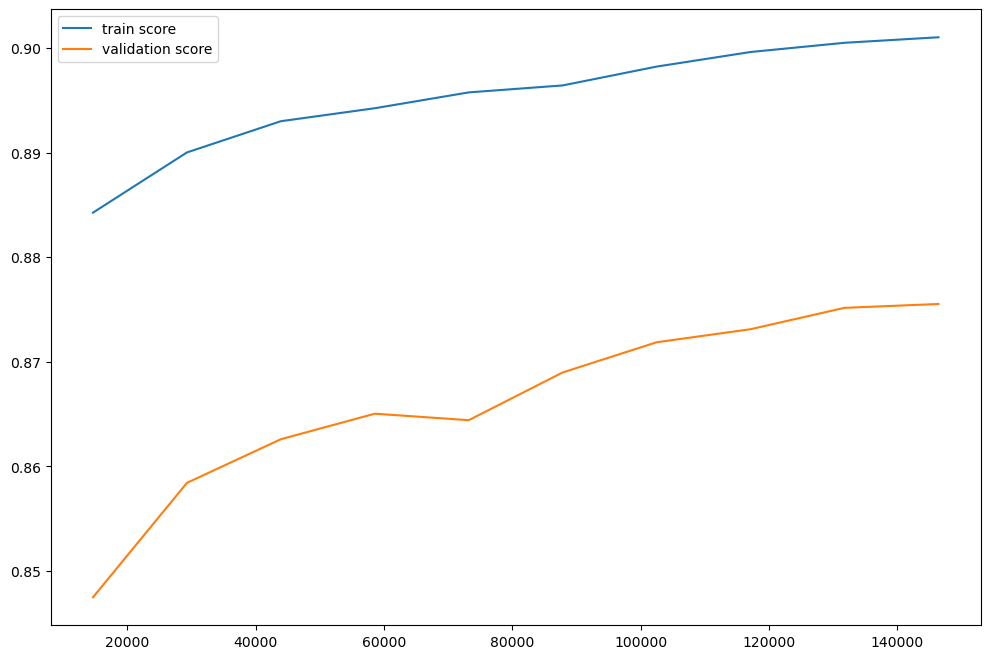

In [9]:
model = best_clf
evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=True)

In [7]:
# Avec les meilleurs paramètres:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# Vectoriser les tokens de la colonne 'ingredients_tokens' du dataframe df.
data = df['ingredients_tokens']

# Créer la matrice des caractéristiques (vectorisation)
matrix = CountVectorizer(max_features=500)
X = matrix.fit_transform(data).toarray()
print(f"Shape of X: {X.shape}")

# Diviser les données en features (X) et target (y)
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Utiliser les meilleurs paramètres obtenus
best_params = {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10}

# Initialiser le modèle d'arbre de décision avec les meilleurs paramètres
clf = DecisionTreeClassifier(**best_params)

# Entraîner le modèle
clf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Shape of X: (244028, 500)
Accuracy: 0.892451747735934


Lines in 
[[25360  2231]
 [ 3014 18201]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     27591
           1       0.89      0.86      0.87     21215

    accuracy                           0.89     48806
   macro avg       0.89      0.89      0.89     48806
weighted avg       0.89      0.89      0.89     48806

f1_score: 0.87
recall_score: 0.86
precision_score: 0.89


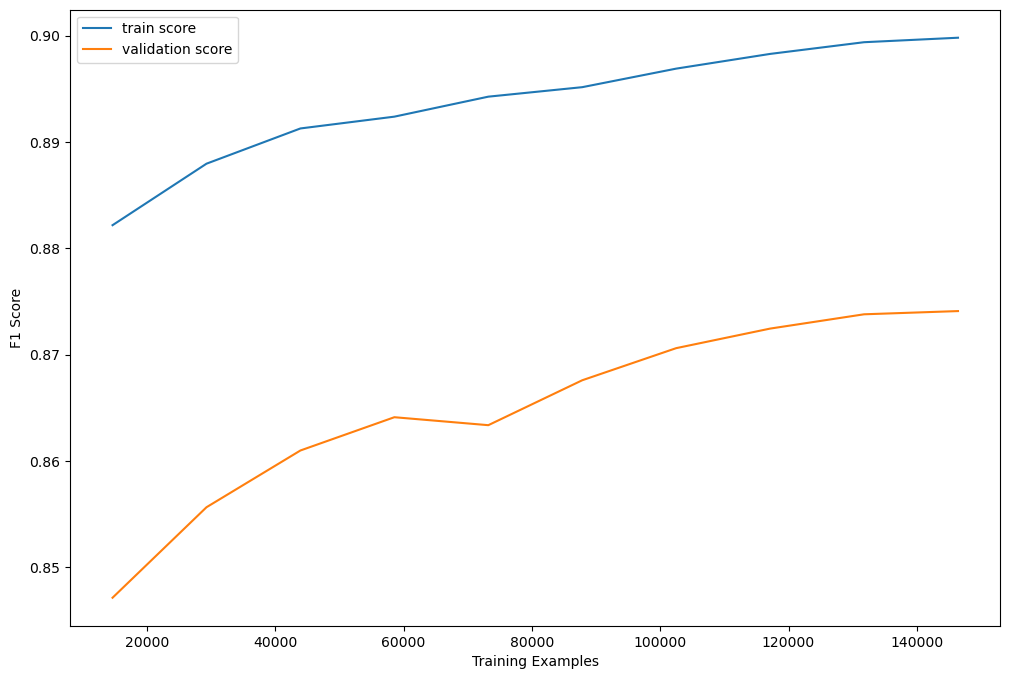

In [9]:
model = clf
evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=True)

In [ ]:
# exporter le modèle clf

# Réseaux de neurones

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Vectorisons les tokens de la colonne 'ingredients_tokens' du dataframe df.
data = df['ingredients_tokens']

# Création de la matrice de caractéristiques avec des 1-grammes
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=500, ngram_range=(1, 1))
X = matrix.fit_transform(data).toarray()

# Diviser les données en features (X) et target (y)
y = df['gluten_presence']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle de réseau de neurones
clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
clf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Calculer l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8872064910052043


Accuracy: 0.8872064910052043

In [33]:
# tester le modèle avec un nouvel échantillon
nouvel_échantillon = ['lait, sucre, oeufs, sel, truffe, gluten-free']
nouvel_échantillon_vectorisé = matrix.transform(nouvel_échantillon).toarray()
prediction = clf.predict(nouvel_échantillon_vectorisé)

if prediction[0] == 1:
    print("Attention: Présence de gluten")
else :
    print("Pas de gluten, faites vous plaisir")

Attention: Présence de gluten


In [42]:
model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=False)

Lines in 
[[24994  2597]
 [ 2908 18307]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     27591
           1       0.88      0.86      0.87     21215

    accuracy                           0.89     48806
   macro avg       0.89      0.88      0.89     48806
weighted avg       0.89      0.89      0.89     48806

f1_score: 0.87
recall_score: 0.86
precision_score: 0.88


In [1]:
# Fonction d'évaluation du modèle, modifiée pour afficher l'étiquette 'score_f1'
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.model_selection import learning_curve

def evaluation(model, X_train, X_test, y_train, y_test, display_learning_curve=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Lines in ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"f1_score: {round(f1_score(y_test, y_pred), 2)}")
    print(f"recall_score: {round(recall_score(y_test, y_pred), 2)}")
    print(f"precision_score: {round(precision_score(y_test, y_pred), 2)}")
    
    if display_learning_curve:
        N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1' , train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(12,8))
        plt.plot(N, train_score.mean(axis=1), label='train score')
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        plt.xlabel('Training examples')
        plt.ylabel('F1-score')
        plt.legend()
        plt.show()